# (7) Signal (CPD) Search and Characterization

In Part (6), we learned that any CPDs of interest in the SR 4 disk should be point sources (i.e., their size is $\ll$ the resolution) and could be pretty faint, perhaps comparable to the residuals from the circumstellar disk model.  We need to develop a means of quantifying what level of emission we are able to robustly detect.  One intuitive way for doing that is to inject a fake signal into the data, perform the same fitting/post-processing analysis we used on the real observations to get a residual dataset, and then try to recover the fake signal.  

For the last part, *recovery*, there is not a widely agreed-upon metric.  We'll have to develop our own approach and demonstrate that it works in practice.  Your goal in this part of the project is to establish an **automated** way to search for and quantify a point source in the SR 4 disk gap.  This machinery should (1) quantify the *significance* of any such feature (i.e., its signal-to-noise ratio, or the ratio of the peak to the "local" standard deviation); and (2) measure its flux; and (3) measure its position in the SR 4 disk gap (given how narrow the gap is, the radius should be just about 0.08", but the *azimuth* is unknown a priori).  There are no right or wrong answers here: your job is to experiment and see what might work.  Start simple...if we can make it work with a straightforward search in a (r,az)-map like before, let's do that!

I know this is sort of backwards, worrying about the recovery part before the injection part.  But I think it makes more sense in terms of the work that needs to be done.  The *injection* doesn't involve a lot of activity from a research perspective (its more of just a code machinery in a big loop).  I will show you how that works once your machinery is tested.  To help you develop, I've posted two example residual images online (see below) with mock CPDs already injected.  

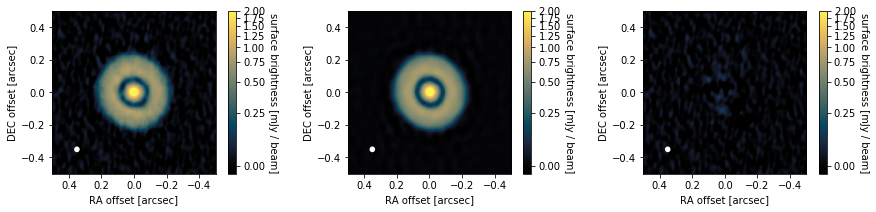

In [1]:

import os, sys, time           
import numpy as np             # Numpy is the basic numerics package in Python.
from astropy.io import fits    # .FITS file manipulation package  
import urllib.request          # package for fetching files off the internet
import matplotlib.pyplot as plt    # plotting package
from matplotlib.patches import Ellipse    # plotting package
import cmasher as cmr          # color maps
from astropy.visualization import (AsinhStretch, LogStretch, ImageNormalize)    # image visualization functions
%matplotlib inline



from astropy.io import fits
import cmasher as cmr          # color maps
from astropy.visualization import (AsinhStretch, LogStretch, LinearStretch, ImageNormalize)    # image visualization functions
from matplotlib.patches import Ellipse    # plotting package

# data
data = fits.open('SR4_data.fits')
dimage = np.squeeze(data[0].data)
dheader = data[0].header

# model
data = fits.open('SR4_model.fits')
mimage = np.squeeze(data[0].data)
mheader = data[0].header

# residual
data = fits.open('SR4_resid.fits')
rimage = np.squeeze(data[0].data)
rheader = data[0].header

# coordinates (all the same)
nx, ny = dheader['NAXIS1'], dheader['NAXIS2']
RA = dheader['CRVAL1'] + dheader['CDELT1'] * (np.arange(nx) - (dheader['CRPIX1'] - 1))
DEC = dheader['CRVAL2'] + dheader['CDELT2'] * (np.arange(ny) - (dheader['CRPIX2'] - 1))
RAo, DECo = 3600 * (RA - dheader['CRVAL1']), 3600 * (DEC - dheader['CRVAL2'])
offRA, offDEC = -0.060, -0.509
RAo_shift, DECo_shift = RAo - offRA, DECo - offDEC
dRA, dDEC = np.meshgrid(RAo_shift, DECo_shift)
im_bounds = (dRA.max(), dRA.min(), dDEC.min(), dDEC.max())

# get the beam parameters (in **arcseconds** for the FWHM, and **degrees** for the position angle)
beam_maj, beam_min, beam_PA = 3600 * dheader['BMAJ'], 3600 * dheader['BMIN'], dheader['BPA']

# now set the RA and DEC offset ranges you want to show
dRA_lims  = [0.5, -0.5]      # (same reverse ordering to ensure E is to the left)
dDEC_lims = [-0.5, 0.5]

# now define the color-map, intensity limits, and stretch
cmap = cmr.eclipse
vmin, vmax = -0.03, 2.0    # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

# set up and plot the image on the specified scale
fig, axs = plt.subplots(ncols=3, figsize=(15,3))

ax = axs[0]
im = ax.imshow(1e3*dimage, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=13)

# make an ellipse to show the PSF (beam) dimensions, in the lower left corner (its very small!)
beam = Ellipse((dRA_lims[0] + 0.15*np.diff(dRA_lims), dDEC_lims[0] + 0.15*np.diff(dDEC_lims)), 
                beam_maj, beam_min, 90-beam_PA)
beam.set_facecolor('w')
ax.add_artist(beam)

ax = axs[1]
im = ax.imshow(1e3*mimage, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=13)

# make an ellipse to show the PSF (beam) dimensions, in the lower left corner (its very small!)
beam = Ellipse((dRA_lims[0] + 0.15*np.diff(dRA_lims), dDEC_lims[0] + 0.15*np.diff(dDEC_lims)), 
                beam_maj, beam_min, 90-beam_PA)
beam.set_facecolor('w')
ax.add_artist(beam)

ax = axs[2]
im = ax.imshow(1e3*rimage, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=13)

# make an ellipse to show the PSF (beam) dimensions, in the lower left corner (its very small!)
beam = Ellipse((dRA_lims[0] + 0.15*np.diff(dRA_lims), dDEC_lims[0] + 0.15*np.diff(dDEC_lims)), 
                beam_maj, beam_min, 90-beam_PA)
beam.set_facecolor('w')
ax.add_artist(beam)

In [15]:
from scipy.interpolate import interp1d
incl, PA = 22, 26
# convert these to radius
inclr, PAr = np.radians(incl), np.radians(PA)

# deproject and rotate to new coordinate frame
xp = (dRA * np.cos(PAr) - dDEC * np.sin(PAr)) / np.cos(inclr)
yp = (dRA * np.sin(PAr) + dDEC * np.cos(PAr))

# now convert to polar coordinates (r in arcseconds, theta in degrees)
# note that theta starts along the minor axis (theta = 0), and rotates clockwise in the sky plane)
r = np.sqrt(xp**2 + yp**2)
theta = np.degrees(np.arctan2(yp, xp))
def razmap(imarray, rbins, tbins):

    # bin widths
    dr = np.abs(rbins[1] - rbins[0])
    dt = np.abs(tbins[1] - tbins[0])
    
    # initialize the (r, az)-map and radial profile
    rtmap = np.empty((len(tbins), len(rbins)))
    stdmap = np.empty((len(tbins), len(rbins)))
    SBr, err_SBr = np.empty(len(rbins)), np.empty(len(rbins))

    # loop through the bins to populate the (r, az)-map and radial profile
    for i in range(len(rbins)):
        # identify pixels that correspond to the radial bin (i.e., in this annulus)
        in_annulus = ((r >= (rbins[i] - 0.5 * dr)) & (r < (rbins[i] + 0.5 * dr)))
    
        # accumulate the azimuth values and surface brightness values in this annulus
        az_annulus = theta[in_annulus]
        SB_annulus = imarray[in_annulus]
    
        # average the intensities (and their scatter) in the annulus
        SBr[i], err_SBr[i] = np.average(SB_annulus), np.std(SB_annulus)
    
        # populate the azimuthal bins for the (r, az)-map at this radius
        for j in range(len(tbins)):
            # identify pixels that correspond to the azimuthal bin
            in_wedge = ((az_annulus >= (tbins[j] - 0.5 * dt)) & (az_annulus < (tbins[j] + 0.5 * dt)))
        
            # if there are pixels in that bin, average the corresponding intensities
            if (len(SB_annulus[in_wedge]) > 0):
                rtmap[j,i] = np.average(SB_annulus[in_wedge])
            else:
                rtmap[j,i] = -1e10    # this is a temporary placeholder; it will be fixed in next piece of code

                
            if (len(SB_annulus[in_wedge]) > 1):
                stdmap[j,i]=np.std(SB_annulus[in_wedge])
            else:
            # this is a temporary placeholder; it will be fixed in next piece of code
                stdmap[j,i]=-1e10
    # now "fix" the (r, az)-map where there are too few pixels in certain az bins (inner disk)
    # its ok if this part is a "black box": it is not important / relevant
    for i in range(len(rbins)):
        # extract an azimuthal slice of the (r, az)-map
        az_slice = rtmap[:,i]
    
        # identify if there's missing information in an az bin along that slice:
        # if so, fill it in with linear interpolation along the slice
        if np.any(az_slice < -1e5):
            # extract non-problematic bins in the slice
            x_slice, y_slice = tbins[az_slice >= -1e5], az_slice[az_slice >= -1e5]
        
            # pad the arrays to make sure they span a full circle in azimuth
            x_slice_ext = np.pad(x_slice, 1, mode='wrap')
            x_slice_ext[0] -= 360.
            x_slice_ext[-1] += 360.
            y_slice_ext = np.pad(y_slice, 1, mode='wrap')
        
            # define the interpolation function
            raz_func = interp1d(x_slice_ext, y_slice_ext, bounds_error=True)
        
            # interpolate and replace those bins in the (r, az)-map
            fixed_slice = raz_func(tbins)
            rtmap[:,i] = fixed_slice
        
    class raz_out:
        def __init__(self, razmap, smap, r, az, prof, eprof):
            self.razmap = razmap
            self.smap=smap
            self.r = r
            self.az = az
            self.prof = prof
            self.eprof = eprof
            
    return raz_out(rtmap, stdmap, rbins, tbins, SBr, err_SBr)
rbins = np.linspace(0.001, 0.5, 200)    # in arcseconds
tbins = np.linspace(-180, 180, 181)     # in degrees

deproj_data = razmap(dimage, rbins, tbins)
deproj_model = razmap(mimage, rbins, tbins)
deproj_resid = razmap(rimage, rbins, tbins)



   
    







In [18]:
from scipy.ndimage.filters import generic_filter
local_stdmap=generic_filter(deproj_data.razmap, np.std, size=3)

In [19]:
import math
from scipy.ndimage.filters import generic_filter
#######Point SOURCE FINDER######
rbins = np.linspace(0.001, 0.5, 200)    # in arcseconds
tbins = np.linspace(-180, 180, 181)     # in degrees
dr = np.abs(rbins[1] - rbins[0])

####Using entire standard deviation of entire gap
def findpoints(t1, r1,r2,p):
    npoint = 1
    blankval=-50
    cut=(rbins>=r1)&(rbins<=r2)
  
    sig=deproj_data.razmap[:,cut]
    
    noi=np.std(sig)
    SN=np.abs(sig/noi)
    fluxba=sig
    rbins2=rbins[cut]
    for j in range(len(tbins)):
        for i in range(len(rbins2)): 
            if SN[j][i]<t1 or SN[j][i]==float('inf'):
                SN[j][i]=blankval
    #initialize output arrays
    rf =np.zeros(npoint)
    tf=np.zeros(npoint)
    SNp=np.zeros(npoint)
    rr =np.zeros(npoint)
    tt=np.zeros(npoint)
    fluxbap=np.zeros(npoint)
    for i in range(npoint):
        indmax = np.argmax(SN)
        tt[i], rr[i]=np.unravel_index(indmax, SN.shape)
        tf[i], rf[i]=tbins[int(tt[i])], rbins2[int(rr[i])]
        
        
        
        SNp[i]=SN[int(tt[i]), int(rr[i])]
        ti, ri=int(tt[i]), int(rr[i])
        fluxbap[i]=fluxba[ti, ri]
        cut2=(rbins2>=rf[i]-p) & (rbins2<=rf[i]+p)
        tgap=math.atan(p/(rf[i]))
        cut3=(tbins>=tf[i]-tgap) & (tbins<=tf[i]+tgap)
        SN[cut3,cut2]=blankval
        print(i, rf[i], tf[i], SNp[i], fluxbap[i])
    return rf, tf
findpoints(0.1, 0.075, 0.085, 2*dr)


#####Code implementing local standard deviation
def findpoints2(t1, r1,r2,p):
    npoint = 1
    blankval=-50
    cut=(rbins>=r1)&(rbins<=r2)
  
    sig=deproj_data.razmap[:,cut]
    
    noi=local_stdmap[:,cut]
    SN=np.abs(sig/noi)
    fluxba=sig
    rbins2=rbins[cut]
    for j in range(len(tbins)):
        for i in range(len(rbins2)): 
            if SN[j][i]<t1 or SN[j][i]==float('inf'):
                SN[j][i]=blankval
    #initialize output arrays
    rf =np.zeros(npoint)
    tf=np.zeros(npoint)
    SNp=np.zeros(npoint)
    rr =np.zeros(npoint)
    tt=np.zeros(npoint)
    fluxbap=np.zeros(npoint)
    for i in range(npoint):
        indmax = np.argmax(SN)
        tt[i], rr[i]=np.unravel_index(indmax, SN.shape)
        tf[i], rf[i]=tbins[int(tt[i])], rbins2[int(rr[i])]
        
        
        
        SNp[i]=SN[int(tt[i]), int(rr[i])]
        ti, ri=int(tt[i]), int(rr[i])
        fluxbap[i]=fluxba[ti, ri]
        cut2=(rbins2>=rf[i]-p) & (rbins2<=rf[i]+p)
        tgap=math.atan(p/(rf[i]))
        cut3=(tbins>=tf[i]-tgap) & (tbins<=tf[i]+tgap)
        SN[cut3,cut2]=blankval
        print(i, rf[i], tf[i], SNp[i], fluxbap[i])
    return rf, tf
findpoints(0.1, 0.075, 0.085, 2*dr)
findpoints2(0.1, 0.075, 0.085, 2*dr)




0 0.07622613065326633 14.0 5.44089679348372 0.00024913763627409935
0 0.07622613065326633 14.0 5.44089679348372 0.00024913763627409935
0 0.08124120603015075 -136.0 133.4915486243895 0.00018822676065610722


(array([0.08124121]), array([-136.]))

In [36]:
rbins = np.linspace(0.001, 0.5, 200)    # in arcseconds
tbins = np.linspace(-180, 180, 181)     
res=deproj_resid.razmap
sig=deproj_data.razmap
SN=sig/res
cut=(rbins>=0.45)&(rbins<0.5)
h=SN[:,cut]
cutop=h>1.31
t=h[cutop]



print(SN[:,cut])
print(sig.shape)
print(len(rbins[cut]))
print(SN[:,cut].shape)
print(t.shape)
print(t)
l=np.reshape(t, (len(tbins),len(rbins[cut])))
print(l)
print(l.shape)

[[  1.3118206    1.38339884   1.46710505 ...   1.09966697   1.1022906
    1.45532862]
 [  2.00701334   2.7121192   -6.98373911 ...  -3.08585329  -1.26970384
    0.24323502]
 [  1.79481453   1.73093781   1.81826    ...   0.24248637   0.41816549
    0.53614233]
 ...
 [  1.30851218   1.13562189  -1.57097167 ... 140.22472211  -0.80292339
   -5.67024033]
 [  0.98538725   1.05285926   1.12577476 ...   1.22938058   1.22612403
    1.19052972]
 [  1.08433475   1.17194146   1.46710505 ...   1.61237982   1.1022906
    1.58085815]]
(181, 200)
19
(181, 19)
(622,)
[  1.3118206    1.38339884   1.46710505   1.58525028   1.74996543
   4.21968277   2.46786099   9.3844878    1.45532862   2.00701334
   2.7121192    1.32810318   1.94344991   1.79481453   1.73093781
   1.81826      1.45637261   2.0962576    1.79288108   1.83136566
   2.32779133  61.6255228    1.58215645   2.01460672   1.35113963
   1.90686075   1.60129018   1.38038691   1.76044775   1.7106665
 162.02288269   2.52324597   4.31781352   1.3286

ValueError: cannot reshape array of size 622 into shape (181,19)

Sometime later this week I'll point you to some different models where the mock CPDs should be much harder to find and characterize.  Your method will need to handle such cases also!

In [28]:
print(len(rbins[cut]))

19


In [10]:
print(deproj_data.smap)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.70760266e-07
  0.00000000e+00 1.60120180e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.87224543e-06
  3.39529834e-06 4.36872415e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.93755113e-06
  2.60729553e-06 3.76816138e-06]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.06105726e-05
  9.21611081e-06 6.66217738e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.76115860e-06
  3.34667402e-06 7.62588888e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.96294729e-06
  0.00000000e+00 1.60120180e-06]]


In [30]:
19*181

3439

In [37]:
a = np.arange(12).reshape((3, 4))

In [41]:
a[1][0]

4

In [39]:
a[0][1]

1

In [40]:
print(SN.shape)

(181, 200)


In [13]:
print(deproj_data.smap)


[[-1.00000000e+10 -1.00000000e+10 -1.00000000e+10 ...  7.70760266e-07
  -1.00000000e+10  1.60120180e-06]
 [-1.00000000e+10 -1.00000000e+10 -1.00000000e+10 ...  4.87224543e-06
   3.39529834e-06  4.36872415e-06]
 [-1.00000000e+10 -1.00000000e+10 -1.00000000e+10 ...  1.93755113e-06
   2.60729553e-06  3.76816138e-06]
 ...
 [-1.00000000e+10 -1.00000000e+10 -1.00000000e+10 ...  1.06105726e-05
   9.21611081e-06  6.66217738e-06]
 [-1.00000000e+10 -1.00000000e+10 -1.00000000e+10 ...  6.76115860e-06
   3.34667402e-06  7.62588888e-06]
 [-1.00000000e+10 -1.00000000e+10 -1.00000000e+10 ...  2.96294729e-06
   8.57938630e-06 -1.00000000e+10]]


In [8]:
np.std(5)

0.0

In [17]:
print(local_stdmap)  

[[3.32694658e-05 8.91004159e-05 1.14153145e-04 ... 3.96673477e-06
  5.14879076e-06 5.67383779e-06]
 [3.30300065e-05 8.97749511e-05 1.15434493e-04 ... 4.11000023e-06
  4.74990170e-06 4.92417712e-06]
 [3.26668917e-05 9.07852985e-05 1.17339700e-04 ... 2.22493119e-06
  2.23824223e-06 2.50392014e-06]
 ...
 [3.41193565e-05 8.67746708e-05 1.09721550e-04 ... 1.88011665e-05
  1.67432187e-05 1.48203873e-05]
 [3.37562389e-05 8.77694615e-05 1.11625395e-04 ... 1.68062377e-05
  1.38223424e-05 1.29273083e-05]
 [3.35115622e-05 8.84318737e-05 1.12883315e-04 ... 1.90753177e-05
  1.52616759e-05 1.45167702e-05]]
